### 2. Whitening Data

In [1]:
# Packages that used in this assignment
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

#### Load up the 2D dataset from the file assign0 data.py.

In [2]:
dataset = torch.load('assign0_data.py')

#### Visualize it by making a 2D scatter plot (e.g. using matplotlib).

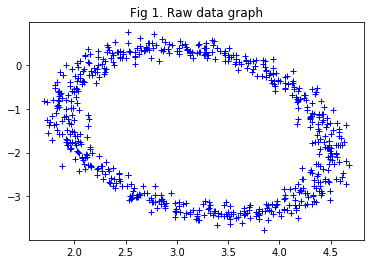

In [3]:
plt.title('Fig 1. Raw data graph')
plt.plot(dataset.t()[0], dataset.t()[1],'b+')

#### Translates the data so that it has zero mean (i.e. is centered at the origin).

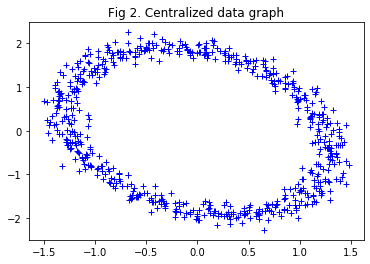

In [4]:
plt.title('Fig 2. Centralized data graph')
z = dataset - torch.mean(dataset, dim = 0)
plt.plot(z.t()[0].numpy(), z.t()[1].numpy(),'b+')

#### Decorrelates the data so that the data covariance is the identity matrix.

Calculate the covariance matrix by eigenvalue decomposition

$$\Sigma = E[XX^T]$$
By eigenvalue decomposition, we have:
$$ \Sigma\Phi = \Phi\Lambda$$
Because $\Phi$ is an orthogonal matrix, we have $\Phi^{-1} = \Phi^T$, thus, we have:
$$\Phi^T\Sigma\Phi = \Lambda$$
which means
$$\Phi^TE[XX^T]\Phi = \Lambda$$
$$E[\Phi^TXX^T\Phi] = \Lambda$$
Then, we know the covariance matrix of $\Phi^TX$ is a diagonal matrix. The last step is to divided $\Phi^TX$ by the square root of the diagonal value. What we get has a identity covariance matrix.

In [5]:
sigma = np.cov(z.T)

In [6]:
w, v = np.linalg.eig(sigma)

In [7]:
y = np.dot(v.T,z.T)

In [8]:
Whitened_data = np.zeros(y.shape)
for i in range(len(y)):
    Whitened_data[i] = y[i]/np.sqrt(w)[i]

In [9]:
np.cov(Whitened_data)

array([[1.00000000e+00, 2.03658746e-16],
       [2.03658746e-16, 1.00000000e+00]])

#### Plot the whitened data.

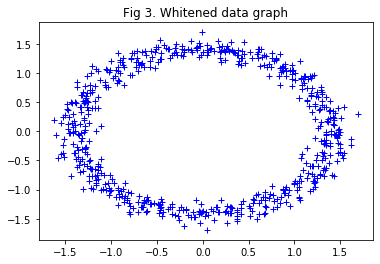

In [10]:
plt.title('Fig 3. Whitened data graph')
plt.plot(Whitened_data[0], Whitened_data[1], 'b+')

#### As a comment in your code, discuss the dependencies present in the whitened data.

As we can see from the Fig 1, 2 and 3, the data actually has a strong dependency because the graph shape looks like an oval. Even if we use try to whitened the data by transforming the covariance matrix to identity, the Fig 3 is still an oval shape graph. Therefore, we can reach to a conclusion that non-linear dependency cannot be cancelled by transforming covariance matrix into identity matrix. By the way, the effect of the transforming is actually a combination of compression and rotation.

### 3. Fitting a 1D function with a simple neural net

In [11]:
PI = math.pi
x = torch.arange(-PI,PI,0.01).reshape(629,1)
y = torch.cos(x)

In [12]:
def nn(x, y, N, D_in, H, D_out):
    '''
    reference: http://pytorch.org/tutorials/beginner/pytorch_with_examples.html
    input:
        x, y are the input dataset 
        N is batch size; 
        D_in is input dimension;
        H is hidden dimension; 
        D_out is output dimension.
    output:
        y_pred is the predicted value by the model
    '''
    # Use the nn package to define our model as a sequence of layers. nn.Sequential
    # is a Module which contains other Modules, and applies them in sequence to
    # produce its output. Each Linear Module computes output from input using a
    # linear function, and holds internal Tensors for its weight and bias.
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.Tanh(),
        torch.nn.Linear(H, D_out),
    )
    initial_model = model(x)
    # The nn package also contains definitions of popular loss functions; in this
    # case we will use Mean Squared Error (MSE) as our loss function.
    loss_fn = torch.nn.MSELoss(reduction='sum')

    learning_rate = 1e-4
    for t in range(10000):
        # Forward pass: compute predicted y by passing x to the model. Module objects
        # override the __call__ operator so you can call them like functions. When
        # doing so you pass a Tensor of input data to the Module and it produces
        # a Tensor of output data.
        y_pred = model(x)

        # Compute and print loss. We pass Tensors containing the predicted and true
        # values of y, and the loss function returns a Tensor containing the
        # loss.
        loss = loss_fn(y_pred, y)
        if t % 1000 == 999:
            print(t, loss.item())

        # Zero the gradients before running the backward pass.
        model.zero_grad()

        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()

        # Update the weights using gradient descent. Each parameter is a Tensor, so
        # we can access its gradients like we did before.
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad
    return initial_model, y_pred

In [13]:
initial_model, y_pred = nn(x, y, len(y), 1, 10, 1)

999 0.09644023329019547
1999 0.08881054818630219
2999 0.08457063883543015
3999 0.08113399893045425
4999 0.0782545953989029
5999 0.07579958438873291
6999 0.07367917895317078
7999 0.07183267921209335
8999 0.07021254301071167
9999 0.0687832236289978


#### The model function initial_model (before training)

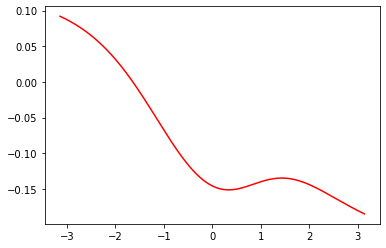

In [14]:
plt.plot(x, initial_model.detach().reshape(len(y)), 'r', label='y')

#### The graph of real function y = cos(x) and modeled function y_pred (after training)

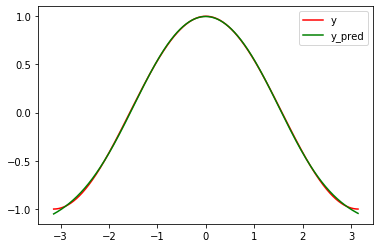

In [15]:
plt.plot(x, y.detach().reshape(len(y)), 'r', label='y')
plt.plot(x, y_pred.detach().reshape(len(y)), 'g', label='y_pred')
plt.legend(loc='upper right')

#### The graph of the absolute error function 

Text(0.5, 1.0, 'The absolute error of the model')

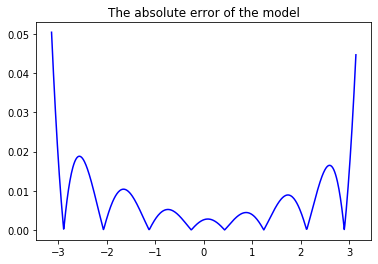

In [16]:
plt.plot(x, torch.abs(y.detach().reshape(len(y)) - y_pred.detach().reshape(len(y))) , 'b', label='y')
plt.title('The absolute error of the model')